In [1]:
import pandas

In [2]:
prediction = pandas.read_csv("./ensemble_train_prediction.csv")

In [3]:
def confusion_matrix(row):
    x = "TN"
    if row['SeriousDlqin2yrs'] == 1:
        if row['Prediction'] == 1:
            x = "TP"
        else:
            x = "FN"
    else:
        if row['Prediction'] == 1:
            x = "FP"
    return x

In [4]:
def get_confusion_matrix(): 
    prediction['Error'] = prediction.apply(confusion_matrix, axis=1)
    return prediction['Error'].value_counts()

In [5]:
print(get_confusion_matrix())

TN    27708
FN     1699
TP      358
FP      235
Name: Error, dtype: int64


In [6]:
final_confusion_matrix = get_confusion_matrix()
accuracy = (final_confusion_matrix['TP'] + final_confusion_matrix['TN'])/300
print(accuracy)

93.55333333333333


In [7]:
prediction[:10]

,Id,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,DebtAbsolute,MonthlyBalance,BalancePerPerson,Prediction,probability,0 probability,1 probability,Error
0,1,0.766127,45,2,0.802982,9120,13,0,6,0,2.0,1,7323.197016,1796.802984,598.934328,0,0.70623,0.70623,0.29377,FN
1,10,0.189169,57,0,0.606291,23684,9,0,4,0,2.0,0,14359.393699,9324.606301,3108.202100,0,0.94970,0.94970,0.05030,TN
2,12,0.018798,51,0,0.531529,6501,7,0,2,0,2.0,0,3455.468469,3045.531531,1015.177177,0,0.98528,0.98528,0.01472,TN
3,13,0.010352,46,0,0.298354,12454,13,0,2,0,2.0,0,3715.701650,8738.298350,2912.766117,0,0.98894,0.98894,0.01106,TN
4,15,0.019657,76,0,477.000000,0,6,0,1,0,0.0,0,477.000000,-477.000000,-477.000000,0,0.99740,0.99740,0.00260,TN
5,17,0.061086,78,0,2058.000000,0,10,0,2,0,0.0,0,2058.000000,-2058.000000,-2058.000000,0,0.99606,0.99606,0.00394,TN
6,25,0.046560,58,0,0.241622,2416,9,0,1,0,0.0,0,583.758378,1832.241622,1832.241622,0,0.98792,0.98792,0.01208,TN
7,34,0.186869,57,0,0.313812,7000,9,0,2,0,0.0,0,2196.686191,4803.313809,4803.313809,0,0.98936,0.98936,0.01064,TN
8,43,0.469057,31,0,0.048211,9250,4,0,0,0,1.0,0,445.951787,8804.048213,4402.024107,0,0.97222,0.97222,0.02778,TN
9,54,0.028562,51,0,0.306381,5750,5,0,1,0,0.0,0,1761.693619,3988.306381,3988.306381,0,0.99556,0.99556,0.00444,TN


In [8]:
filtered = prediction.loc[prediction['Error'].isin(["FN", "FP"])]

filtered = (filtered.nlargest(100, 'probability'))

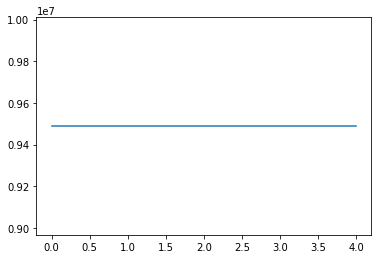

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def threshold_modifier(row, threshold):
    if row['1 probability'] >= threshold:
        row['Prediction'] = 1
    else:
        row['Prediction'] = 0
        
def cost_threshold(threshold):
    prediction.apply(threshold_modifier, axis=1, args=(threshold,))
    matrix = get_confusion_matrix()
    return (matrix['TN']*500) + (matrix['FN']*-2500) + (matrix['FP']*-500)

table = [cost_threshold(n/5) for n in range(0,5)]
plt.plot(table)